In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm


from helpers.physics_functions import bkg_fit_cubic, bkg_fit_septic, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio, calculate_test_statistic
from helpers.evaluation import get_median_percentiles
from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band, stamp
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Try to load LaTeX
latex_flag = False
np.seterr(divide='ignore')

# try:
#     plt.rc('text', usetex=True)
#     plt.rc('font', family='serif')
#     fig, ax = newplot("full", use_tex = True)
#     print("Loaded LaTeX")
#     latex_flag = True
# except:
#     print("Could not load LaTeX")
#     latex_flag = False  
# latex_flag = False

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

This notebook should be run twice:

1. `train_samesign = False` gives the "standard" results. i.e. we run the studies on the OS samples
2. `train_samesign = True` comes from running the Ml study on the SS samples.

**CAUTION**: for the histograms, we are truly showing the significance as $\frac{S}{\sqrt{B+{\sigma_B}^2}}$, i.e. we are accounting for the background error. For the ROC curves, this error is *NOT* being taken into account (it's not clear to me that we want this background error when we are just citing the background yield for the FPR)

In [93]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file) 
    
feature_id = "mix_2"
bootstrap_flow = 0 # don't change this from 0

train_samesign = False
# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "SS"
else:
    train_data_id = "OS"

# train on opp sign means alt test set is samesign
if train_data_id == "OS": 
    alt_test_data_id = "SS"
elif train_data_id == "SS": 
    alt_test_data_id = "OS"

configs = "CATHODE_8"


# pickles contain all the results from the BDT training
working_dir = workflow["file_paths"]["working_dir"]
processed_data_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/"+workflow["analysis_keywords"]["name"]+"/processed_data"
flow_training_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/models/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/{configs}/"
pickle_save_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/pickles/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/"
plot_data_dir = "plot_data/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 1
n_folds = 5

In [94]:
num_bins_SR = 12 # 16, 12, 8

pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)
fit_type = "quintic" # "cubic", "quintic", septic
if fit_type == "cubic": fit_function = bkg_fit_cubic
if fit_type == "quintic": fit_function = bkg_fit_quintic
if fit_type == "septic": fit_function = bkg_fit_septic


In [95]:
SB_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_left"])
SR_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_left"])
SR_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_right"])
SB_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_right"])

print(SB_left, SB_right)
print(SR_left, SR_right)


data_prefix = f"upsilon_{train_data_id}"
print(data_prefix)

5.0 16.0
9.0 10.6
upsilon_OS


# Load in the original data

In [96]:
# # load in the data corresponding to the train id
# # we actually want the "test band" here -- train is just for flow
# with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{train_data_id}_{jet_id}_test_band_data", "rb") as infile: 
#     test_data_dict = pickle.load(infile)

# with open(f"{working_dir}/models/{project_id}_{particle_type}{train_data_id}_{jet_id}/{flow_id}/{config_id}/seed1/configs.txt", "rb") as infile: 
#     configs = infile.readlines()[0].decode("utf-8")
    
#     feature_set = [x.strip() for x in configs.split("'")][1::2]

# print(f"Feature Set: {feature_set}")

## Load in the BDT results

In [97]:

print(f"Loading data from {flow_training_dir}")
with open(f"{flow_training_dir}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(f"Feature Set: {feature_set}")

Loading data from /global/cfs/cdirs/m3246/rmastand/dimuonAD//projects/upsilon_iso_12_03/models/bootstrap0_OS/mix_2/CATHODE_8/
Feature Set: ['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']


In [98]:
# if train_samesign = False, this loads in the OS test data
# test 


def load_in_pseudoexperiments(file_string, num_pseudoexps):

    master_dict = {}

    with open(f"{pickle_save_dir}/{file_string}_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
        loc_dict = pickle.load(ifile)
    master_dict = {**loc_dict}
    # load in the bootstraps
    for i in range(1, num_pseudoexps):
        with open(f"{pickle_save_dir}/bkg_samples/bootstrap{i}/{file_string}_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
            loc_dict = pickle.load(ifile)
            master_dict[i] = loc_dict[0]
    return master_dict

num_to_plot = num_pseudoexperiments

all_test_data_splits = load_in_pseudoexperiments("all_test_data_splits", num_to_plot)
print(len(all_test_data_splits.keys())==num_pseudoexperiments)

# test scores
all_scores_splits = load_in_pseudoexperiments("all_scores_splits", num_to_plot)
print(len(all_scores_splits.keys())==num_pseudoexperiments)

# alt data
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
all_alt_data_splits = load_in_pseudoexperiments("all_alt_data_splits", num_to_plot)
print(len(all_alt_data_splits.keys())==num_pseudoexperiments)
# alt scores
all_alt_scores_splits = load_in_pseudoexperiments("all_alt_scores_splits", num_to_plot)

print(len(all_alt_scores_splits.keys())==num_pseudoexperiments)

with open(f"{processed_data_dir}/mass_scaler_bootstrap{bootstrap_flow}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
with open(f"{processed_data_dir}/preprocessing_info_bootstrap{bootstrap_flow}", "rb") as ifile:
     preprocessing_info = pickle.load(ifile)

True


True
True
True


/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Plot histograms for a small number of FPR thresholds

In [99]:
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]


# Save the FPR thresholds
with open(f"{plot_data_dir}{data_prefix}_fpr_thresholds", "wb") as ofile:
    pickle.dump(fpr_thresholds, ofile)

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff

In [100]:
def plot_upsilon_resonances(ax):

    
    # plot the upsilon resonances
    ax.axvline(9.460, color="black", linestyle="--", alpha=0.15)
    # ax.text(9.460 * 0.995, 1e4, r"$\Upsilon(1S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.023, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.023 * 0.995, 1e4, r"$\Upsilon(2S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.355, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.355 * 0.995, 1e4, r"$\Upsilon(3S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.580, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.580 * 0.995, 1e4, r"$\Upsilon(4S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    # ax.axvline(11.020, color="black", linestyle="--", alpha=0.15)
    # ax.text(11.020 * 0.995, 1e4, r"$\Upsilon(5S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)

In [101]:
def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, n_folds= 5, take_score_avg=True,):
    

    save_data = {}
    save_data["fpr_thresholds"] = fpr_thresholds
    save_data["fit_type"] = fit_type
    save_data["num_bins_SR"] = num_bins_SR
    save_data["popts"] = []
    save_data["pcovs"] = []
    save_data["significances"] = []
    save_data["filtered_masses"] = []
    save_data["y_vals"] = []


    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    if fit_type == "cubic": degree = 3
    elif fit_type == "quintic": degree = 5
    elif fit_type == "septic": degree = 7

    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)




    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_masses = []

        # for each fold, select the events that meet the fpr threshold
        for i_fold in range(n_folds):
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
            loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs_by_fold[i_fold][threshold],plot_bins_left, plot_bins_right, plot_bins_SR)
            filtered_masses.append(loc_filtered_masses)
        # consolidate the fold information
        filtered_masses = np.concatenate(filtered_masses)

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
    
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
        function_with_band(ax, fit_function, [SB_left, SB_right], popt, pcov, color = f"C{t}")

# def function_with_band(ax, f, range, params, pcov = None, color = "purple", alpha_line = 0.75, alpha_band = 0.25, lw = 3,  **kwargs):


        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)
        S, B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = degree, starting_guess = popt)

        # test_statistic(masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov, ONE_SIDED = True, verbose = False)

        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        total_events = len(filtered_masses)



        label_string = str(round(100*threshold, 2))+"% FPR: "+str(total_events)+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))

        # hist_with_errors(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        # hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


        save_data["popts"].append(popt)
        save_data["pcovs"].append(pcov)
        save_data["significances"].append(np.sqrt(q0))
        save_data["filtered_masses"].append(filtered_masses)
        save_data["y_vals"].append(y_vals)



    line1 = f"{num_bins_SR -1 } Bins in SR"
    line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
    line3 = r"Muon Iso_04 $\geq$ 0.55"
    line4 = r"~6% of Original Data"

    starting_x = 0.05
    starting_y = 0.8
    delta_y = 0.04
    text_alpha = 0.75
    ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)


    legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"
    plt.legend(loc = (0.465, 0.575), fontsize = 14, title = legend_title, title_fontsize = 16)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    plt.yscale("log")
    # plt.ylim(0.5, 1e3)
    plt.ylim(0.01, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    plot_upsilon_resonances(ax)
    

    # # Vertical Black Lines at boundaries of SR
    # plt.axvline(SR_left, color = "black", linestyle = "--", lw = 2)
    # plt.axvline(SR_right, color = "black", linestyle = "--", lw = 2)


    # plt.title(title, fontsize = 24)
    return save_data
    


<>:110: SyntaxWarning: invalid escape sequence '\m'
<>:110: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_43432/2635557706.py:110: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)


Saved Data to plot_data/upsilon_OS_histogram_data_quintic_12.pickle


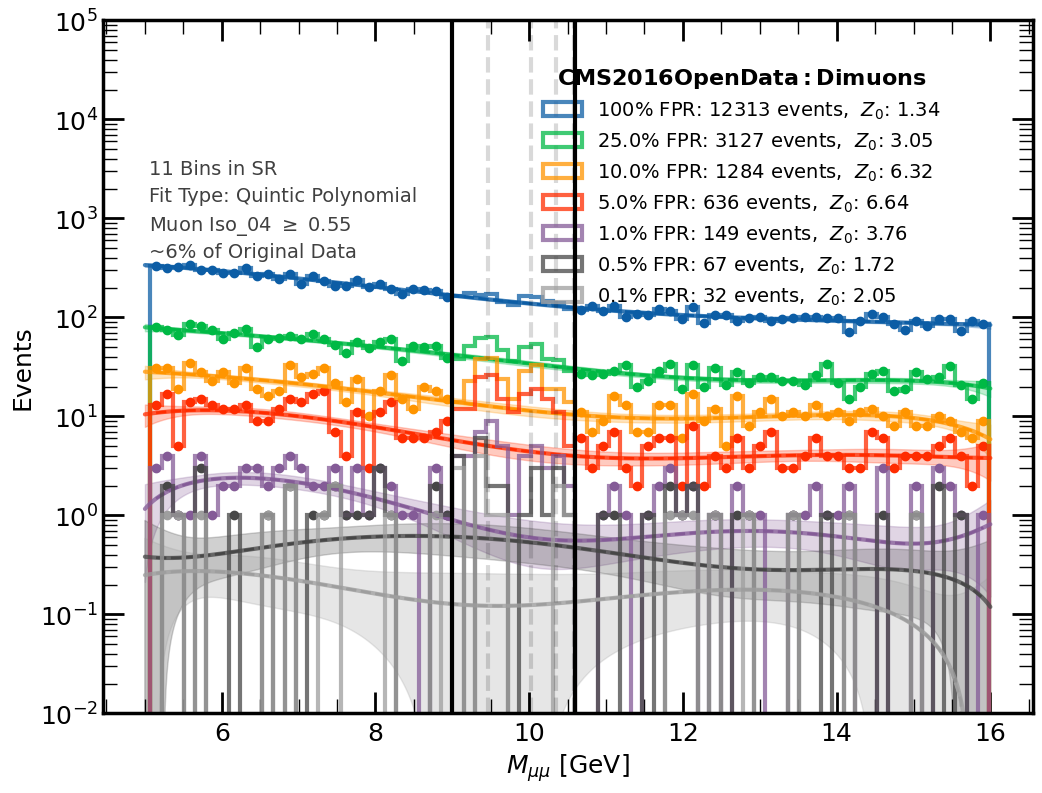

In [102]:

"""
PLOT HISTOGRAM ON SMALL TEST SET
"""
pseudo_e_to_plot = 0
save_data = plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"upsilon OS\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_histogram_data_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)

print("Saved Data to " + f"{plot_data_dir}{data_prefix}_histogram_data_{fit_type}_{num_bins_SR}.pickle")

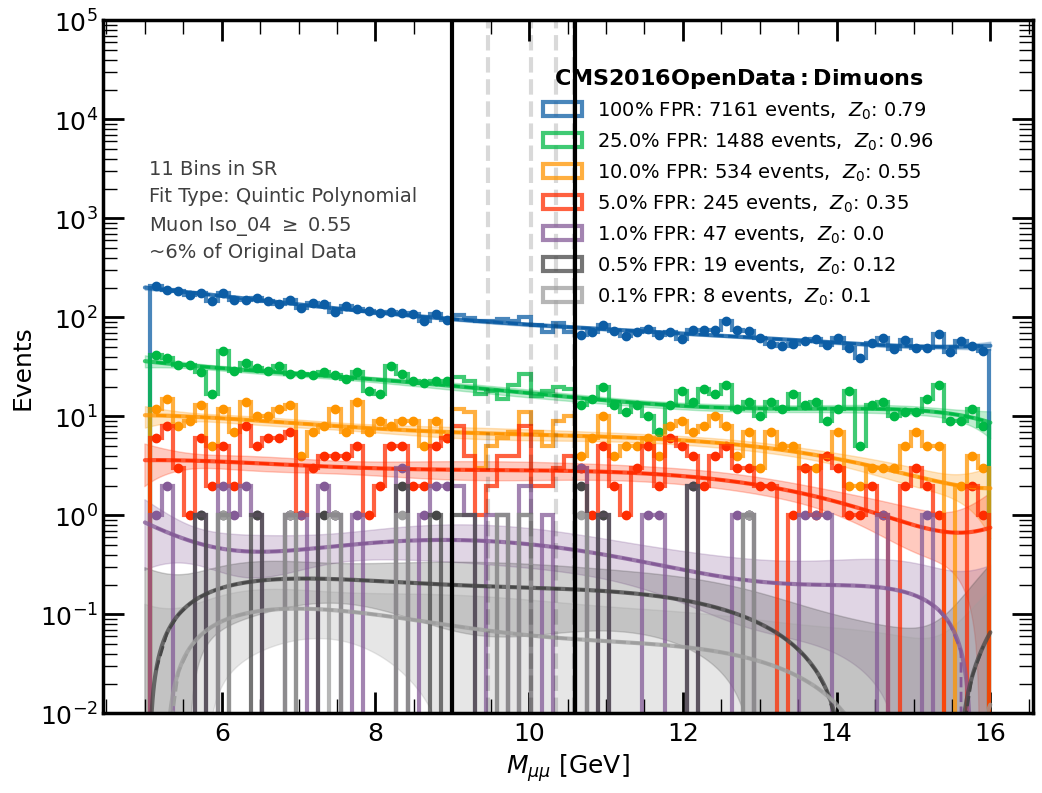

In [103]:


"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""
save_data = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type, f"upsilon SS",SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_histogram_data_alt_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)


In [104]:
"""
PLOT HISTOGRAM ON ROC TEST DATA
"""
# this plot won't be shown in the main body -- this is just the high-stats set that is used to create the ROC curve

#plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)



'\nPLOT HISTOGRAM ON ROC TEST DATA\n'

In [105]:
# """
# PLOT HISTOGRAM ON FLOW SAMPLES
# """
# plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


# Classical Studies

In [106]:
# from helpers.plotting import feature_bins


# def plot_feature_cuts(feature, fpr_thresholds, test_data_dict, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, flip = False):
#     """
#     Plot the feature cuts for the given data, scores, and score cutoffs.

#     Parameters
#     ----------
#     feature : str
#         The feature to plot the cuts for.
#     fpr_thresholds : list
#         The list of FPR thresholds to plot.
#     test_data_dict : dict
#         The dictionary of test data.
#     mass_scalar : sklearn.preprocessing.StandardScaler
#         The mass scaler.
#     fit_type : str
#         The type of fit to use for the background.
#     title : str
#         The title of the plot.
#     SB_left : float
#         The left side of the sideband.
#     SR_left : float
#         The left side of the signal region.
#     SR_right : float
#         The right side of the signal region.
#     SB_right : float
#         The right side of the sideband.
#     """

        
#     save_data = {}
#     save_data["fpr_thresholds"] = fpr_thresholds
#     save_data["fit_type"] = fit_type
#     save_data["num_bins_SR"] = num_bins_SR
#     save_data["popts"] = []
#     save_data["pcovs"] = []
#     save_data["significances"] = []
#     save_data["filtered_masses"] = []
#     save_data["y_vals"] = []

#     # Unpack the data dictionary to extract the feature of interest 
#     feature_SBL = test_data_dict["SBL"]["s_inj_data"][feature]
#     feature_SR = test_data_dict["SR"]["s_inj_data"][feature]
#     feature_SBH = test_data_dict["SBH"]["s_inj_data"][feature]

#     if flip:
#         feature_SBL = -feature_SBL
#         feature_SR = -feature_SR
#         feature_SBH = -feature_SBH

#     # Unpack the data dictionary to extract the dimuon mass spectrum
#     mass_SBL = mass_scalar.inverse_transform(np.array(test_data_dict["SBL"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
#     mass_SR = mass_scalar.inverse_transform(np.array(test_data_dict["SR"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
#     mass_SBH = mass_scalar.inverse_transform(np.array(test_data_dict["SBH"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))

#     # Get a list of all possible cuts for the feature
#     feature_cut_points = np.linspace(np.min(feature_SBL), np.max(feature_SBH), 1000)

#     # For each cut, calculate the number of signal and background events in the SR
#     num_in_SBL = []
#     num_in_SR = []
#     num_in_SBH = []
#     FPR = []
#     for cut in feature_cut_points:
#         num_in_SBL.append(np.sum(feature_SBL >= cut))
#         num_in_SR.append(np.sum(feature_SR >= cut))
#         num_in_SBH.append(np.sum(feature_SBH >= cut))


#         # @RADHA: I am estimating the FPR of each cut by the amount the sideband gets reduced. I cannot parse how you have done it above.
#         # FPR is the combination of SBH and SBL
#         FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))

    
#     # Set up fit types
#     if fit_type == "cubic": fit_function = bkg_fit_cubic
#     elif fit_type == "quintic": fit_function = bkg_fit_quintic
#     elif fit_type == "septic": fit_function = bkg_fit_septic

#     plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

#     fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}


#     # fig, ax = newplot("full", aspect_ratio = 1.5)
#     fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
#     for t, threshold in enumerate(fpr_thresholds):


#         # Use interpolation to find the cut point that gives the desired FPR
#         best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

#         # Make the cuts to both the feature and the mass
#         feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
#         feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
#         feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

#         mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
#         mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
#         mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

#         # Concatenate to get the full mass spectrum
#         filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
        

#         # get the fit function to SB background
#         # popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv_CLASSICAL(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_SR, plot_bins_right, plot_centers_all)
#         popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
#         #print("chi2/dof:", chi2/n_dof)
        
#         # plot the fit function
#         plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    

#         # calculate significance of bump
#                 # calculate significance of bump
#         if ONE_SIDED:
#             num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, ONE_SIDED)
#             q0 = calculate_test_statistic(filtered_masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov)


#             y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
#             B_error = np.sqrt(np.sum(y_err**2))
#             S_over_B = num_S_expected_in_SR/num_B_expected_in_SR

            

#         label_string = str(round(100*threshold, 2))+"% FPR: "+str(len(feature_SBL_cut)+len(feature_SR_cut)+len(feature_SBH_cut))+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))


#         hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string, alpha_1 = 0.1, alpha_2 = 0.5)
#         # plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
#         plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


#         save_data["popts"].append(popt)
#         save_data["pcovs"].append(pcov)
#         save_data["significances"].append(np.sqrt(q0))
#         save_data["filtered_masses"].append(filtered_masses)
#         save_data["y_vals"].append(y_vals)

#     line1 = f"{num_bins_SR -1 } Bins in SR"
#     line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
#     line3 = r"Muon Iso_04 $\geq$ 0.55"
#     line4 = r"~6% of Original Data"

#     starting_x = 0.475
#     starting_y = 0.45
#     delta_y = 0.04
#     text_alpha = 0.75
#     ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
#     ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
#     ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
#     ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)


#     legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$: "+feature
#     plt.legend(loc = (0.465, 0.575), fontsize = 14, title = legend_title, title_fontsize = 16)


#     plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
#     plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

#     plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
#     plt.ylabel("Events", fontsize = 18)

#     # plt.yscale("log")
#     plt.ylim(0.5, 1e3)

#     # Add more x ticks (major and minor)
#     plt.xticks(fontsize = 18)
#     plt.yticks(fontsize = 18)
#     plt.minorticks_on()
#     plt.tick_params(axis='x', which='minor', bottom=True)
#     plt.tick_params(axis='y', which='minor', left=True)

#     plot_upsilon_resonances(ax)

#     return save_data


In [107]:
# flip_features = [False, True, True]
# for feature in feature_set[:-1]:
#     print(feature)
#     save_data =  plot_feature_cuts(feature, fpr_thresholds, test_data_dict, scaler, fit_type, f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})", SB_left, SR_left, SR_right, SB_right, flip = flip_features[feature_set.index(feature)])
#     with open(f"{plot_data_dir}{data_prefix}_feature_cut_data_{feature}_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
#         pickle.dump(save_data, ofile)


In [108]:
n_folds = 5

"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -3, 25)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff



n_folds = 5

"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff


        
def get_classifier_metrics_high_stats(dataset_by_pseudo_e, scores_by_pseudo_e, mass_scalar):

    if fit_type == "cubic": degree = 3
    if fit_type == "quintic": degree = 5
    if fit_type == "septic": degree = 7
            

    num_experiments = num_pseudoexperiments
    S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_experiments)), np.empty((fpr_thresholds_finegrained.shape[0], num_experiments))
    significances = np.empty((fpr_thresholds_finegrained.shape[0], num_experiments))


    for pseudo_e in range(num_experiments):

        data_dict_by_fold = dataset_by_pseudo_e[pseudo_e]
        scores_dict_by_fold = scores_by_pseudo_e[pseudo_e]

        all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
        all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
        all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))
        in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
        in_SBL = (all_masses < SR_left )
        in_SBH = (all_masses > SR_right )

        mass_SBL = all_masses[in_SBL]
        mass_SR = all_masses[in_SR]
        mass_SBH = all_masses[in_SBH]

        feature_SBL = all_scores[in_SBL]
        feature_SR = all_scores[in_SR]
        feature_SBH = all_scores[in_SBH]
        
        # Get a list of all possible cuts for the feature
        feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)

         # For each cut, calculate the number of signal and background events in the SR
        num_in_SBL = []
        num_in_SR = []
        num_in_SBH = []
        FPR = []
        for cut in feature_cut_points:
            num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
            num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
            num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

            FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))



        print(f"On pseudo experiment {pseudo_e+1}...")
        for t, threshold in enumerate(fpr_thresholds_finegrained):


            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]


            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

             # calculate significance of bump
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            S,B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = degree, starting_guess = popt, verbose_plot = False)
            print("S: ", S, "B: ", B, "sqrt(q0): ", np.sqrt(q0))

            significances[t, pseudo_e] = np.sqrt(q0)

        
    
    return significances



In [109]:
test = all_alt_data_splits[0]["alt"][0]
print(test)

test = all_test_data_splits[0]
print(test.keys())

[[-0.30334359 -1.15857506  3.35292578  0.43714195]
 [-0.23972486 -0.37708494 -0.42117029  0.15533382]
 [-0.47238263 -0.83464962  0.1226217  -1.02116442]
 ...
 [ 1.23497939 -0.30098721  1.10236311  0.2833088 ]
 [ 0.72366327 -0.29456356  1.24911141  1.69428086]
 [ 0.77595931 -0.07558635 -1.2014364  -1.16374636]]
dict_keys([0, 1, 2, 3, 4])


In [110]:
# Reformat alt to not have the 'alt' key
all_alt_data_splits_formatted = {}
all_alt_scores_splits_formatted = {}
for pseudo_e in range(num_pseudoexperiments):
    all_alt_data_splits_formatted[pseudo_e] = all_alt_data_splits[pseudo_e]["alt"]
    all_alt_scores_splits_formatted[pseudo_e] = all_alt_scores_splits[pseudo_e]["alt"]


print(all_scores_splits.keys())

dict_keys([0])


In [111]:
significances = get_classifier_metrics_high_stats(all_test_data_splits, all_scores_splits, scaler)
with open(f"{plot_data_dir}{data_prefix}_significances_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(significances, ofile)


significances_alt = get_classifier_metrics_high_stats(all_alt_data_splits_formatted, all_alt_scores_splits_formatted, scaler)
with open(f"{plot_data_dir}{data_prefix}_significances_alt_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(significances_alt, ofile)




On pseudo experiment 1...
S:  83.90822474080028 B:  1608.0917752591997 sqrt(q0):  1.673733937691351
S:  107.91602253361862 B:  1196.0839774663814 sqrt(q0):  2.1614754491605943
S:  99.10196524872924 B:  923.8980347512708 sqrt(q0):  2.392690891129234
S:  127.49988449390594 B:  670.5001155060941 sqrt(q0):  3.1047438483838983
S:  108.54564042866468 B:  523.4543595713353 sqrt(q0):  2.9901103215772946
S:  105.94424322675877 B:  387.0557567732412 sqrt(q0):  3.345370584119417
S:  117.2029541234163 B:  277.7970458765837 sqrt(q0):  4.2202016983932955
S:  137.06943385754735 B:  203.93056614245265 sqrt(q0):  5.5378380087906915
S:  113.26412594142582 B:  161.73587405857418 sqrt(q0):  5.161746960608437
S:  109.79610205353504 B:  116.20389794646496 sqrt(q0):  5.639844022251574
S:  81.84877977156476 B:  96.15122022843524 sqrt(q0):  4.761494382824935
S:  73.42726669259369 B:  79.57273330740631 sqrt(q0):  5.34603528233096
S:  66.15488635660037 B:  57.84511364339963 sqrt(q0):  4.812663557653308
S:  65.12

In [112]:
from helpers.plotting import feature_bins


def feature_cut_ROCS(feature, test_data_splits, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, flip = False, index = 0, random = False):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """


    if fit_type == "cubic": degree = 3
    if fit_type == "quintic": degree = 5
    if fit_type == "septic": degree = 7


    num_experiments = num_pseudoexperiments
    fpr_thresholds = fpr_thresholds_finegrained
    S_yield = np.zeros((len(fpr_thresholds), num_experiments))
    B_yield = np.zeros((len(fpr_thresholds), num_experiments))
    background_errors = np.zeros((len(fpr_thresholds), num_experiments))
    significances = np.zeros((len(fpr_thresholds), num_experiments))



    for (e, pseudo_e) in enumerate(tqdm(range(num_experiments))):

        all_nfolds = np.concatenate([test_data_splits[pseudo_e][i] for i in range(n_folds)])
        

        if random:
            feature_of_interest = np.random.uniform(0, 1, len(all_nfolds[:,-1]))
        else:
            feature_of_interest = all_nfolds[:,index]

        # mean = np.nanmean(feature_of_interest)
        # feature_of_interest = np.nan_to_num(feature_of_interest, nan = mean)

        masses = mass_scalar.inverse_transform(np.array(all_nfolds[:,-1]).reshape(-1,1))[:,0]

        # mean = np.nanmean(masses)
        # masses = np.nan_to_num(masses, nan = mean)

        if flip:
            feature_of_interest = -feature_of_interest
           

        # Split into SBL, SR, and SBH
        # print(masses.shape, feature_of_interest.shape)
        feature_SBL = feature_of_interest[masses < SR_left]
        feature_SR = feature_of_interest[(masses >= SR_left) & (masses <= SR_right)]
        feature_SBH = feature_of_interest[masses > SR_right]




        # Get a list of all possible cuts for the feature
        mass_SBL = masses[masses < SR_left]
        mass_SR = masses[(masses >= SR_left) & (masses <= SR_right)]
        mass_SBH = masses[masses > SR_right]

        # print(mass_SBL.shape, mass_SR.shape, mass_SBH.shape)
        # print(feature_SBL.shape, feature_SR.shape, feature_SBH.shape)

        feature_cut_points = np.linspace(np.min(feature_of_interest), np.max(feature_of_interest), 10000)

        FPR = []
        for cut in feature_cut_points:
            FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))


        # Set up fit types
        if fit_type == "cubic": fit_function = bkg_fit_cubic
        elif fit_type == "quintic": fit_function = bkg_fit_quintic
        elif fit_type == "septic": fit_function = bkg_fit_septic


        plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)
        fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}



        # fig, ax = newplot("full", aspect_ratio = 1.5)
        for t, threshold in enumerate(fpr_thresholds):


            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]
            # print(np.min(feature_of_interest), np.max(feature_of_interest), best_feature_cut)

            # Make the cuts to both the feature and the mass
            feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
            feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
            feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

    

            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]


            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

            # calculate significance of bump
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
           
            S,B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = degree, starting_guess = popt, verbose_plot = False)
            print("S: ", S, "B: ", B, "sqrt(q0): ", np.sqrt(q0))

            significances[t, pseudo_e] = np.sqrt(q0)

    
    return significances


In [113]:

feature_SIGs = {}
feature_SIGs_alt = {}

flip_features = [False, True, True, False] 



#"dimu_pt", "mu0_ip3d", "mu1_ip3d", 
for (i, feature) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "random"]):
# for (i, feature) in enumerate(["dimu_pt"]):
    print(feature)
    feature_SIGs[feature] = feature_cut_ROCS(feature, all_test_data_splits, scaler, fit_type, f"", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i, random = (feature == "random"))

    with open(f"{plot_data_dir}{data_prefix}_significances_{feature}_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(feature_SIGs[feature], ofile)

  
for (i, feature) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "random"]):
# for (i, feature) in enumerate(["dimu_pt"]):
    print(feature)
    feature_SIGs_alt[feature] = feature_cut_ROCS(feature, all_alt_data_splits_formatted, scaler, fit_type, f"", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i, random = (feature == "random"))

    with open(f"{plot_data_dir}{data_prefix}_significances_alt_{feature}_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(feature_SIGs_alt[feature], ofile)

  


dimu_pt


  0%|          | 0/1 [00:00<?, ?it/s]

S:  83.90822474080028 B:  1608.0917752591997 sqrt(q0):  1.673733937691351
S:  45.7165350279754 B:  1154.2834649720246 sqrt(q0):  0.8774767407660694
S:  100.64910369658082 B:  815.3508963034192 sqrt(q0):  2.269156772886353
S:  106.58837752304441 B:  552.4116224769556 sqrt(q0):  2.8725373099011806
S:  97.9942863036191 B:  392.0057136963809 sqrt(q0):  3.1257703159915837
S:  67.70900303790137 B:  262.29099696209863 sqrt(q0):  2.6441062057495754
S:  59.94710164426746 B:  174.05289835573254 sqrt(q0):  2.7948503448433364
S:  44.59578255804236 B:  117.40421744195764 sqrt(q0):  2.521428412010834
S:  24.14366482212567 B:  85.85633517787433 sqrt(q0):  1.6413440324822774
S:  16.29685768175807 B:  60.70314231824193 sqrt(q0):  1.3325963753636578
S:  2.8265864074618463 B:  50.173413592538154 sqrt(q0):  0.2704209027686661
S:  4.077393158731255 B:  30.922606841268745 sqrt(q0):  0.4847952554617524
S:  -3.7358047258675597 B:  22.73580472586756 sqrt(q0):  0.0
S:  4.019065906671333 B:  12.980934093328667 s

100%|██████████| 1/1 [02:25<00:00, 145.50s/it]


S:  2.240362404595351 B:  0.759637595404649 sqrt(q0):  1.93923347623095
mu0_ip3d


  0%|          | 0/1 [00:00<?, ?it/s]

S:  83.90822474080028 B:  1608.0917752591997 sqrt(q0):  1.673733937691351
S:  111.7161957920514 B:  1075.2838042079486 sqrt(q0):  2.174675475734166
S:  111.1785267641992 B:  735.8214732358008 sqrt(q0):  2.5925634872078613
S:  107.33872963022901 B:  507.661270369771 sqrt(q0):  2.978000964751406
S:  67.93548847546106 B:  342.06451152453894 sqrt(q0):  2.302112556039893
S:  58.21557620553958 B:  227.78442379446042 sqrt(q0):  2.380645115276972
S:  68.38855503339846 B:  149.61144496660154 sqrt(q0):  3.305612902012051
S:  72.01709352209787 B:  95.98290647790213 sqrt(q0):  4.11756540938425
S:  48.02713856471972 B:  62.97286143528028 sqrt(q0):  3.5677816024579205
S:  47.533977872742675 B:  39.466022127257325 sqrt(q0):  3.9429594766239435
S:  32.54836905178006 B:  29.45163094821994 sqrt(q0):  3.2146236941445148
S:  21.53585957324451 B:  18.46414042675549 sqrt(q0):  2.9752418869317787
S:  21.762774621859784 B:  9.237225378140215 sqrt(q0):  3.219792370440307
S:  5.798362980562716 B:  12.2016370194

100%|██████████| 1/1 [02:02<00:00, 122.94s/it]


S:  -0.06004105651932207 B:  0.06004105651932207 sqrt(q0):  0.0
mu1_ip3d


  0%|          | 0/1 [00:00<?, ?it/s]

S:  83.90822474080028 B:  1608.0917752591997 sqrt(q0):  1.673733937691351
S:  130.89069942169363 B:  1077.1093005783064 sqrt(q0):  2.5430522019902093
S:  147.35819013730122 B:  729.6418098626988 sqrt(q0):  3.43225078101189
S:  125.21406808854249 B:  512.7859319114575 sqrt(q0):  3.476312070659358
S:  91.61471387089335 B:  364.38528612910665 sqrt(q0):  3.0355803160421293
S:  50.1683052589749 B:  254.8316947410251 sqrt(q0):  2.019765496777596
S:  43.18301218803731 B:  162.8169878119627 sqrt(q0):  2.1313794471081233
S:  37.628468017025696 B:  111.3715319829743 sqrt(q0):  2.2194758160644183
S:  38.53057225578526 B:  75.46942774421474 sqrt(q0):  2.6965658959494747
S:  36.66531625088504 B:  45.33468374911496 sqrt(q0):  3.106023750253901
S:  27.050674083701583 B:  29.949325916298417 sqrt(q0):  2.7793790677750896
S:  25.33835761063621 B:  15.661642389363791 sqrt(q0):  3.301347994273215
S:  20.189479393414736 B:  9.810520606585262 sqrt(q0):  3.253483816112813
S:  7.316138820838718 B:  9.68386117

100%|██████████| 1/1 [02:18<00:00, 138.11s/it]


S:  1.5442750204999953 B:  0.45572497950000473 sqrt(q0):  1.6815211087247453
random


  0%|          | 0/1 [00:00<?, ?it/s]

S:  83.90822474080028 B:  1608.0917752591997 sqrt(q0):  1.673733937691351
S:  55.00602611884915 B:  1085.9939738811509 sqrt(q0):  1.2416276609038128
S:  57.61039115581059 B:  731.3896088441894 sqrt(q0):  1.372242975816582
S:  16.655875742427156 B:  514.3441242575728 sqrt(q0):  0.5515756105096108
S:  7.9698741118265275 B:  341.0301258881735 sqrt(q0):  0.2819356216861668
S:  11.781492849893823 B:  228.21850715010618 sqrt(q0):  0.5065161162877305
S:  -10.780034883842035 B:  170.78003488384203 sqrt(q0):  0.0
S:  -3.982236346538272 B:  117.98223634653827 sqrt(q0):  0.0
S:  -2.5944858973727634 B:  78.59448589737276 sqrt(q0):  0.0
S:  4.616367395424433 B:  47.38363260457557 sqrt(q0):  0.43107644632817055
S:  3.0017864084966845 B:  35.998213591503315 sqrt(q0):  0.32805667384296505
S:  10.313006563202677 B:  20.686993436797323 sqrt(q0):  1.7602040493857447
S:  8.0989670846534 B:  13.9010329153466 sqrt(q0):  1.2944383880308887
S:  7.551891793454628 B:  6.448108206545372 sqrt(q0):  1.682920148442

100%|██████████| 1/1 [02:24<00:00, 144.81s/it]


S:  -0.1782683915544701 B:  0.1782683915544701 sqrt(q0):  0.0
dimu_pt


  0%|          | 0/1 [00:00<?, ?it/s]

S:  35.94918055339997 B:  953.0508194466 sqrt(q0):  0.756472185456218
S:  11.87615987298318 B:  692.1238401270168 sqrt(q0):  0.32321747754266544
S:  -2.542531934386716 B:  507.5425319343867 sqrt(q0):  0.0
S:  -4.779587898567456 B:  370.77958789856746 sqrt(q0):  0.0
S:  -4.729252676606507 B:  256.7292526766065 sqrt(q0):  0.0
S:  -2.122170743414131 B:  174.12217074341413 sqrt(q0):  0.0
S:  0.660105003800254 B:  121.33989499619975 sqrt(q0):  0.425235818155584
S:  4.976467268735661 B:  77.02353273126434 sqrt(q0):  0.4166056017826297
S:  -0.14446040364568802 B:  51.14446040364569 sqrt(q0):  0.0
S:  9.108989821058024 B:  28.891010178941976 sqrt(q0):  1.03743870305724
S:  8.833060507670535 B:  20.166939492329465 sqrt(q0):  1.2328717807013123
S:  6.059788030761743 B:  13.940211969238257 sqrt(q0):  1.0238954395275106
S:  4.158372903375215 B:  5.841627096624785 sqrt(q0):  0.97071263604256
S:  1.7094778623849765 B:  5.2905221376150235 sqrt(q0):  0.5019699803904062
S:  0.5386409225533342 B:  4.461

100%|██████████| 1/1 [01:57<00:00, 117.49s/it]


S:  -0.23523230242289672 B:  0.23523230242289672 sqrt(q0):  0.0
mu0_ip3d


  0%|          | 0/1 [00:00<?, ?it/s]

S:  35.94918055339997 B:  953.0508194466 sqrt(q0):  0.756472185456218
S:  36.67354310381495 B:  646.326456896185 sqrt(q0):  0.9358516393480774
S:  54.23613002558767 B:  436.76386997441233 sqrt(q0):  1.659413877247714
S:  -11.092109224228693 B:  327.0921092242287 sqrt(q0):  0.0
S:  -4.9229594695347885 B:  210.9229594695348 sqrt(q0):  0.0
S:  -10.141078434770947 B:  140.14107843477095 sqrt(q0):  0.0
S:  7.961259269671515 B:  86.03874073032848 sqrt(q0):  0.5376195648658807
S:  -0.09265653600647283 B:  62.09265653600647 sqrt(q0):  0.0
S:  -11.551858773118099 B:  50.5518587731181 sqrt(q0):  0.0
S:  -3.8087422989086406 B:  35.80874229890864 sqrt(q0):  0.0
S:  -6.689895977730238 B:  29.689895977730238 sqrt(q0):  0.0
S:  -3.1336548609532464 B:  18.133654860953246 sqrt(q0):  0.0
S:  -0.8284963355685235 B:  13.828496335568524 sqrt(q0):  0.0
S:  1.8782327858611207 B:  8.12176721413888 sqrt(q0):  0.6358309016555959
S:  2.1565278114489255 B:  5.8434721885510745 sqrt(q0):  0.8442785538149497
S:  1.6

100%|██████████| 1/1 [01:52<00:00, 112.03s/it]


S:  -0.11511419316763823 B:  0.11511419316763823 sqrt(q0):  0.0
mu1_ip3d


  0%|          | 0/1 [00:00<?, ?it/s]

S:  35.94918055339997 B:  953.0508194466 sqrt(q0):  0.756472185456218
S:  42.53272354535841 B:  649.4672764546416 sqrt(q0):  1.0825439376810737
S:  24.561830658960673 B:  445.4381693410393 sqrt(q0):  0.8522896652982719
S:  44.13102097068764 B:  289.86897902931236 sqrt(q0):  1.648377214385847
S:  44.283579741545026 B:  191.71642025845497 sqrt(q0):  2.024388419376342
S:  31.866466944204802 B:  127.1335330557952 sqrt(q0):  1.767792480027022
S:  21.732318108560534 B:  82.26768189143947 sqrt(q0):  1.4981540255835606
S:  17.929184158038332 B:  55.07081584196167 sqrt(q0):  1.4827121356592157
S:  8.649003055860128 B:  43.35099694413987 sqrt(q0):  1.0125595040018194
S:  0.626389826774254 B:  27.373610173225746 sqrt(q0):  0.3047656119958899
S:  1.9567296045158926 B:  20.043270395484107 sqrt(q0):  0.515816932663488
S:  1.1046349933729651 B:  13.895365006627035 sqrt(q0):  0.29253391820882274
S:  -3.2926359243728083 B:  10.292635924372808 sqrt(q0):  0.0
S:  -3.759811595726312 B:  8.759811595726312 

100%|██████████| 1/1 [01:42<00:00, 102.97s/it]


S:  0.684445105270514 B:  0.3155548947294859 sqrt(q0):  0.9684928834438168
random


  0%|          | 0/1 [00:00<?, ?it/s]

S:  35.94918055339997 B:  953.0508194466 sqrt(q0):  0.756472185456218
S:  11.13061844588458 B:  638.8693815541154 sqrt(q0):  0.28769280569243005
S:  -1.6849399404723613 B:  447.68493994047236 sqrt(q0):  0.0
S:  1.4694368596337881 B:  293.5305631403662 sqrt(q0):  0.05607488225107425
S:  6.680538897716616 B:  196.31946110228338 sqrt(q0):  0.5850731594056131
S:  -0.5971475691943056 B:  137.5971475691943 sqrt(q0):  0.0
S:  -20.831588787589467 B:  105.83158878758947 sqrt(q0):  0.0
S:  -11.715641484719114 B:  69.71564148471911 sqrt(q0):  0.0
S:  -13.752893802375418 B:  48.75289380237542 sqrt(q0):  0.0
S:  -13.651016137914652 B:  34.65101613791465 sqrt(q0):  0.0
S:  -18.386268034042402 B:  31.386268034042402 sqrt(q0):  0.0
S:  -15.690183650661801 B:  20.6901836506618 sqrt(q0):  0.0
S:  -13.044354466562279 B:  15.044354466562279 sqrt(q0):  0.0
S:  -7.370928558420198 B:  9.370928558420198 sqrt(q0):  0.0
S:  -3.746055053554783 B:  4.746055053554783 sqrt(q0):  0.0
S:  -4.320725358862774 B:  5.320

100%|██████████| 1/1 [02:08<00:00, 128.19s/it]

S:  -0.2409009050816422 B:  0.2409009050816422 sqrt(q0):  0.0


In [114]:
# Add the ordinary TPR, FPR, ROC, SIC to dictionary with key "CATHODE"
feature_SIGs["CATHODE"] = significances
feature_SIGs_alt["CATHODE"] = significances_alt


[1.67373394 0.87747674 2.26915677 2.87253731 3.12577032 2.64410621
 2.79485034 2.52142841 1.64134403 1.33259638 0.2704209  0.48479526
 0.         2.18837188 1.22636562 0.         0.         0.23419728
 0.175829   1.71957709 2.15416803 1.08830263 1.62674307 1.62674307
 1.93923348]
max observed significance 3.1257703159915837
[1.67373394 2.17467548 2.59256349 2.97800096 2.30211256 2.38064512
 3.3056129  4.11756541 3.5677816  3.94295948 3.21462369 2.97524189
 3.21979237 1.54923621 0.77852991 1.02194539 0.64258143 0.6348168
 0.49236982 0.8068291  0.         0.         0.         0.
 0.        ]
max observed significance 4.11756540938425
[1.67373394 2.5430522  3.43225078 3.47631207 3.03558032 2.0197655
 2.13137945 2.21947582 2.6965659  3.10602375 2.77937907 3.30134799
 3.25348382 1.57073008 2.6666421  1.8512581  1.5795726  1.8819726
 1.95712391 2.44372371 2.00571495 1.85341012 1.92852009 1.92852009
 1.68152111]
max observed significance 3.476312070659358
[1.67373394 2.16147545 2.39269089 3.

<>:68: SyntaxWarning: invalid escape sequence '\P'
<>:68: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_43432/215735003.py:68: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


(0.0, 10.0)

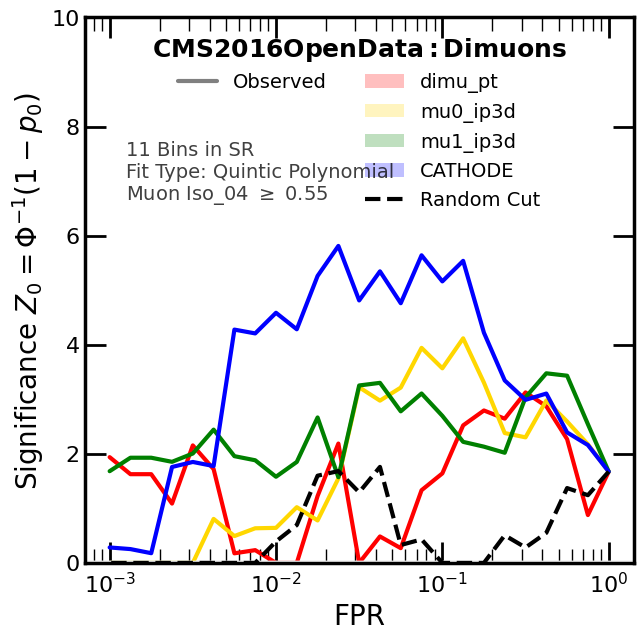

In [115]:
def get_median_percentiles(x_array):
    
    x_median = np.nanmedian(x_array, axis = 1)
    x_lower = np.percentile(x_array, 16, axis = 1)
    x_upper = np.percentile(x_array, 84, axis = 1)

    x_2lower = np.percentile(x_array, 2.5, axis = 1)
    x_2upper = np.percentile(x_array, 97.5, axis = 1)

    return x_median, x_lower, x_upper, x_2lower, x_2upper


# FPR Variant of SIC
fig, ax = newplot("full", use_tex = latex_flag)
colors = ["red", "gold", "green", "blue"]
for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):

    SIG_observed = feature_SIGs[key][:,0]
    print(SIG_observed)
    # SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs[key][:,1:])
    # # SIG_median = SIG_observed
    # # SIG_lower = SIG_observed
    # # SIG_upper = SIG_observed
    # # SIG_2lower = SIG_observed
    # # SIG_2upper = SIG_observed

    # print(key)
    # index = 0
    # print("max observed significance", np.max(SIG_observed))
    # print("Original Significance", SIG_observed[index])
    # print("Median significance", SIG_median[index])
    # print("+1sigma significance", SIG_lower[index], SIG_upper[index])
    # print("+2sigma significance", SIG_2lower[index], SIG_2upper[index])

    # print("Percent of 0", np.sum(feature_SIGs[key][index,1:] == 0)/len(feature_SIGs[key][index,1:]))
    

    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i])

    # ax.plot(fpr_thresholds_finegrained, SIG_median, color = colors[i], linestyle = "dashed", alpha = 0.5)
    # ax.fill_between(fpr_thresholds_finegrained, SIG_lower, SIG_upper, alpha = 0.1, color = colors[i])
    # ax.fill_between(fpr_thresholds_finegrained, SIG_2lower, SIG_2upper, alpha = 0.1, color = colors[i])

    print("max observed significance", np.max(SIG_observed))

# Artificially make a legend
# plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
plt.axhline(0, color = "Grey", label = "Observed")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_SIGs.keys()) 
for i in range(num_features):
    plt.axhline(0, color = "white", label = " ")


# Add the keys in a seperate column with filled color
for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):
    ax.hist([-1], color = colors[i], alpha = 0.25, label = key, histtype = "stepfilled")


# print(feature_SIGs["CATHODE"][:,0])

SIG_observed = feature_SIGs["random"][:,0]
# SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs["random"][:,1:])

ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = "black", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line1 = f"{num_bins_SR -1 } Bins in SR"
line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r""

starting_x = 0.075
starting_y = 0.775
delta_y = 0.04
text_alpha = 0.75
ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"

plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)
plt.xscale("log")
plt.ylim(0.0, 10)
# plt.yscale("log")

# ax.plot(FPR_median, SIC_median, color = "black", label = r"CATHODE")
# ax.fill_between(FPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = "black")
# ax.plot(FPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")
# ax.set_xlabel("FPR")
# ax.set_ylabel("Signifance Improvement")

# legend_title = "Original Signifiance = {###}"
# plt.legend(title = legend_title, loc = "upper right")
# plt.xscale("log")
# plt.ylim(0, 6)

<>:48: SyntaxWarning: invalid escape sequence '\P'
<>:48: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_43432/110416016.py:48: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


(0.0, 10.0)

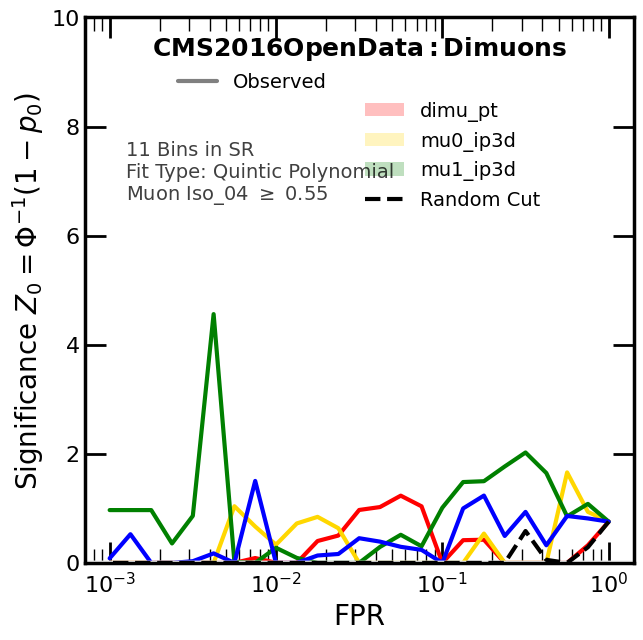

In [116]:
# same plot but for the alternative data

fig, ax = newplot("full", use_tex = latex_flag)
colors = ["red", "gold", "green", "blue", "black"]

for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):

    SIG_observed = feature_SIGs_alt[key][:,0]
    # SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs_alt[key][:,1:])
    # SIG_median = SIG_observed
    # SIG_lower = SIG_observed
    # SIG_upper = SIG_observed
    # SIG_2lower = SIG_observed
    # SIG_2upper = SIG_observed
    


    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i])

    if key == "random":
        ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = colors[i], alpha = 0.5)
        # ax.fill_between(fpr_thresholds_finegrained, SIG_lower, SIG_upper, alpha = 0.1, color = colors[i])
        # ax.fill_between(fpr_thresholds_finegrained, SIG_2lower, SIG_2upper, alpha = 0.1, color = colors[i])


# Artificially make a legend
# plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
plt.axhline(0, color = "Grey", label = "Observed")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_SIGs.keys())
for i in range(num_features):
    plt.axhline(0, color = "white", label = " ")

# Add the keys in a seperate column with filled color

for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d"]):

    ax.hist([-1], color = colors[i], alpha = 0.25, label = key, histtype = "stepfilled")

# print(feature_SIGs["CATHODE"][:,0])

SIG_observed = feature_SIGs_alt["random"][:,0]
# SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs_alt["random"][:,1:])

ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = "black", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line1 = f"{num_bins_SR -1 } Bins in SR"
line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r""

starting_x = 0.075
starting_y = 0.775
delta_y = 0.04
text_alpha = 0.75
ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"

plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)

plt.xscale("log")
plt.ylim(0.0, 10)
# plt.yscale("log")




